In [1]:
import sys
sys.path.append('..')

In [2]:
# Load data
from utils import load_train_val_data, load_test_data

X_train, X_val, y_train, y_val = load_train_val_data()
X_test, y_test, = load_test_data()

📥 Loading train/val data...
✅ Data loaded:
   X_train: (3000, 5000)
   X_val: (1200, 5000)
   y_train: 3000 samples
   y_val: 1200 samples
🚨 Loading TEST data - use only for final evaluation!
✅ Test data loaded:
   X_test: (300, 5000)
   y_test: 300 samples


In [3]:
from utils import ModelTrainer

# Create trainer (same config as RF)
trainer = ModelTrainer(
    cv_folds=8,
    scoring='f1_weighted', 
    n_trials=20,
    random_state=42,
    verbose=True
)

In [4]:
from utils import ModelEvaluator

evaluator = ModelEvaluator()

# Scaling Experiment

In [ ]:
from utils.SimpleScaler import SimpleScaler
from models.LogisticRegressionModel import LogisticRegressionModel

# QUICK SCALING COMPARISON
print("⚡ SCALING IMPACT TEST")
print("=" * 30)

# Test 1: No scaling
print("\n🧪 Testing WITHOUT scaling...")
lr_unscaled = LogisticRegressionModel(
    solver='lbfgs',  # Changed from liblinear to avoid warnings
    max_iter=3000    # Increased iterations
)
lr_unscaled.name = "LR_Unscaled"

unscaled_results = trainer.train_model(
    model=lr_unscaled,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    optimize=False
)

# Test 2: With scaling

print(f"Data type: {type(X_train)}")
print(f"Is sparse: {hasattr(X_train, 'sparse') or 'sparse' in str(type(X_train)).lower()}")

# Convert to dense if sparse (this fixes the StandardScaler issue)
if hasattr(X_train, 'toarray'):
    print("Converting sparse matrix to dense...")
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    X_test_dense = X_test.toarray()
else:
    X_train_dense = X_train
    X_val_dense = X_val
    X_test_dense = X_test

# Now scale the dense data
scaler = SimpleScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform_split(X_train_dense, X_val_dense)
X_test_scaled = scaler.transform(X_test_dense)

lr_scaled = LogisticRegressionModel(
    solver='lbfgs',  # Using lbfgs instead of liblinear
    max_iter=3000
)
lr_scaled.name = "LR_Scaled"

scaled_results = trainer.train_model(
    model=lr_scaled,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    optimize=False
)

# Compare
print(f"\n📊 SCALING COMPARISON:")
print(f"   Unscaled: {unscaled_results['val_accuracy']:.4f}")
print(f"   Scaled:   {scaled_results['val_accuracy']:.4f}")
print(f"   Improvement: {scaled_results['val_accuracy'] - unscaled_results['val_accuracy']:+.4f}")

In [ ]:
import pickle
import os

# Create directory if it doesn't exist
data_path = "../data/processed/scaled/"
os.makedirs(data_path, exist_ok=True)

file_name = f"scaled_unscaled_data"

unscaled_data = {
    "X_train" : X_train,
    "y_train" : y_train,
    "X_val" : X_val,
    "y_val" : y_val,
    "X_test" : X_test,
    "y_test" : y_test
}

scaled_data = {
    "X_train" : X_train_scaled,
    "y_train" : y_train,
    "X_val" : X_val_scaled,
    "y_val" : y_val,
    "X_test" : X_test_scaled,
    "y_test" : y_test
}


# Save best results
with open(f'{data_path}{file_name}.pkl', 'wb') as f:
    pickle.dump({
        'scaled': scaled_data,
        'unscaled': unscaled_data
    }, f)
    
print(f"💾 Results saved to {file_name}.pkl")

# Model Training

## Load Features

In [5]:
import pickle
def load_features(filename='scaled_unscaled_data.pkl'):
   with open(filename, 'rb') as f:
       data = pickle.load(f)
   
   scaled = data['scaled']
   unscaled = data['unscaled']
   
   return scaled, unscaled

# Create directory if it doesn't exist
data_path = "../data/processed/scaled/"

file_name = f"scaled_unscaled_data"
scaled, unscaled = load_features(filename=f"{data_path}{file_name}.pkl")

data_name = "scaled"
X_train = scaled['X_train']
X_val = scaled['X_val']
X_test = scaled['X_test']

## Training and Evaluation Functions

In [6]:
# Training function to standardise outputs for all experiments

def train(model, model_name, trainer, X_train, y_train, X_val, y_val, optimize = True, param_space=None):
    
    model.name = model_name

    print(f"🎯 Training {model_name} with Bayesian Optimization...")

    # Train with comprehensive hyperparameter optimization
    training_results = trainer.train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        param_space=param_space,
        optimize=optimize 
    )

    print(f"\n🔍 {model_name} Training Results:")
    if training_results['optimization']:
        opt = training_results['optimization']
        print(f"   Optimization completed: {opt['n_trials']} trials in {opt['optimization_time']:.1f}s")
        print(f"   Best CV Score: {opt['best_score']:.4f}")
        print(f"   Best Parameters: {opt['best_params']}")

    print(f"   Final CV Score: {training_results['cv_mean']:.4f} ± {training_results['cv_std']:.4f}")
    print(f"   Train Accuracy: {training_results['train_accuracy']:.4f}")
    print(f"   Val Accuracy: {training_results['val_accuracy']:.4f}")
    print(f"   Overfitting Gap: {training_results['train_accuracy'] - training_results['val_accuracy']:.4f}")

    return training_results

In [7]:
# evaluation function to standardise model evaluation

def evaluate(model, model_name, evaluator, X_train, y_train, X_val, y_val, X_test, y_test):

    # Comprehensive evaluation with test set
    print(f"\n📊 Running comprehensive evaluation...")
    eval_results = evaluator.evaluate_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val, 
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        model_name=model_name
    )

    # Print detailed evaluation report
    evaluator.print_detailed_report(model_name)

    # Plot overfitting analysis across models
    evaluator.plot_overfitting_analysis()

    # Plot confusion matrix
    evaluator.plot_confusion_matrix(model_name)

    return eval_results

In [8]:
import os
import pickle

# save experiment function to standardise experiment saving
experiment_path = "../models/trained/LogisticRegression/"

def save_experiment(data, filename, dir=experiment_path):
    os.makedirs(dir, exist_ok=True)  
    with open(f"{dir}{filename}", "wb") as file:
        pickle.dump(data, file)
    print(f"Experiment saved to {dir}{filename}")
    


## Baseline Model

### Baseline Model Training

In [9]:
from models import LogisticRegressionModel

# Create baseline RandomForest with default parameters
lr = LogisticRegressionModel(random_state=42
)

lr_name = f"Baseline_LR_{data_name}"

lr_train_results = train(model = lr, 
      model_name = lr_name, 
      trainer = trainer,
      X_train = X_train, 
      y_train = y_train, 
      X_val = X_val, 
      y_val = y_val, 
      optimize = False)

🎯 Training Baseline_LR_scaled with Bayesian Optimization...
🚀 Training Baseline_LR_scaled...
🔧 Fitting Baseline_LR_scaled...


/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


✅ Baseline_LR_scaled fitted in 19.82 seconds
🔄 Running 8-fold cross-validation...


/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Ei

✅ Baseline_LR_scaled completed in 85.6s
   CV: 0.6630 ± 0.0257
   Train: 0.9190
   Val: 0.7075 (gap: 0.2115)

🔍 Baseline_LR_scaled Training Results:
   Final CV Score: 0.6630 ± 0.0257
   Train Accuracy: 0.9190
   Val Accuracy: 0.7075
   Overfitting Gap: 0.2115


### Baseline Model Evaluation


📊 Running comprehensive evaluation...
📊 Evaluating Baseline_LR_scaled...
✅ Evaluation completed for Baseline_LR_scaled
   Train Acc: 0.9190, F1: 0.9186
   Val Acc: 0.7075, F1: 0.7045 (max gap: 0.2141)
   Test Acc: 0.3733, F1: 0.3704

📋 DETAILED EVALUATION REPORT: Baseline_LR_scaled
📊 PERFORMANCE SUMMARY:
   TRAIN : Acc=0.9190, F1-W=0.9186, F1-M=0.9186
   VAL   : Acc=0.7075, F1-W=0.7045, F1-M=0.7045
   TEST  : Acc=0.3733, F1-W=0.3704, F1-M=0.3704

⚠️  OVERFITTING ANALYSIS:
   Severity: severe
   Max Gap: 0.2141
   accuracy_gap: 0.2115
   f1_weighted_gap: 0.2141

🎯 PER-CLASS PERFORMANCE (Test Set):
   Good Fit    : F1=0.3250, P=0.4333, R=0.2600
   No Fit      : F1=0.4179, P=0.4158, R=0.4200
   Potential Fit: F1=0.3682, P=0.3165, R=0.4400

🔍 FEATURE IMPORTANCE (linear_coef):
   Top 5 indices: [  50 4104   48 2873 4947]
   Mean coefficient: 0.0420
   Std coefficient: 0.0429

📊 CLASSIFICATION REPORT SUMMARY:
   Macro Avg: F1=0.3704, P=0.3886, R=0.3733
   Weighted Avg: F1=0.3704, P=0.3886, 

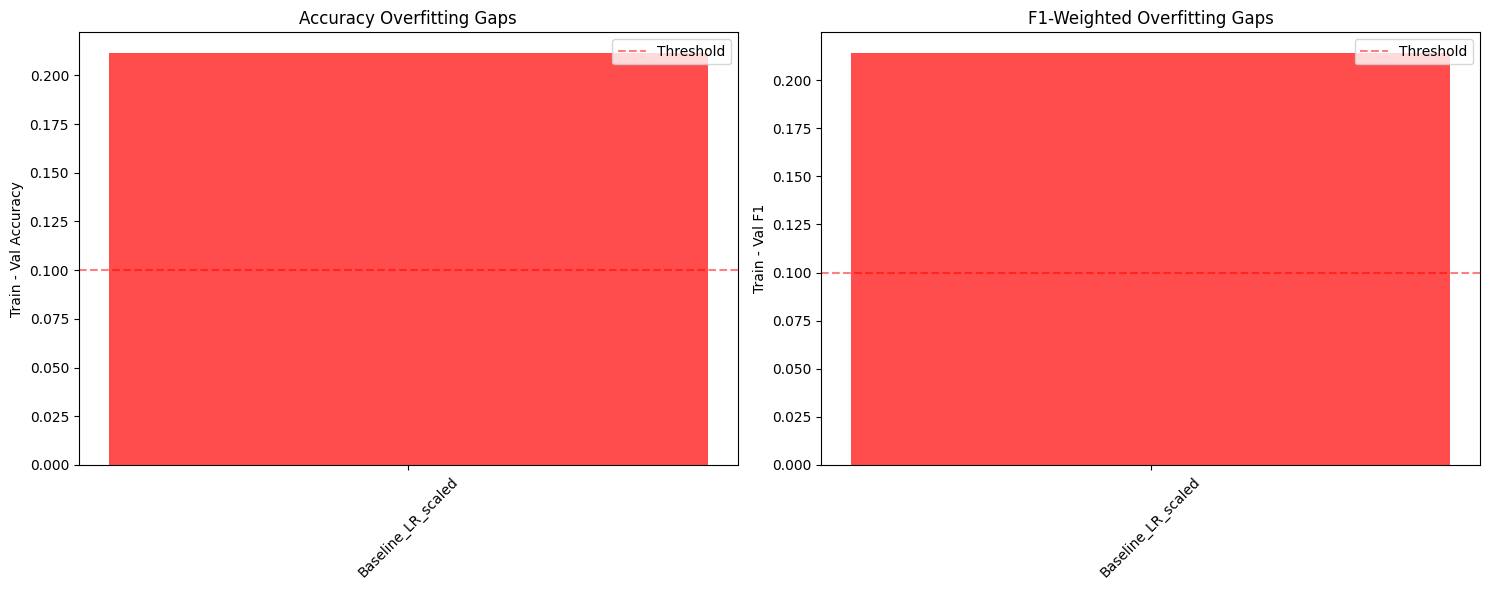

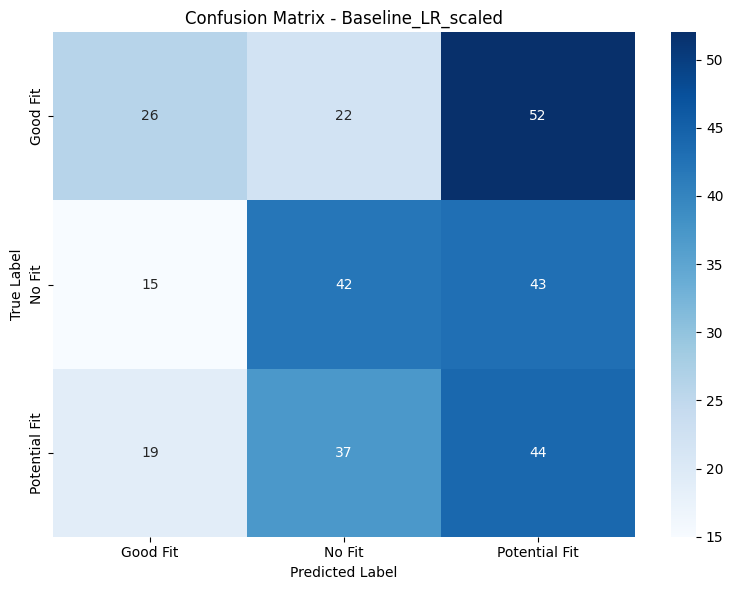

Experiment saved to ../models/trained/LogisticRegression/Baseline_LR_scaled.pkl


In [10]:
# evaluation function to standardise model evaluation
lr_eval_results = evaluate(
    model = lr,
    model_name = lr_name,
    evaluator = evaluator,
    X_train = X_train,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test
)

experiment_name = lr_name

lr_experiment = {
    "experiment_name" : experiment_name,
    "model" : lr,
    "train_results" : lr_train_results,
    "eval_results" : lr_eval_results
}

save_experiment(lr_experiment, f"{experiment_name}.pkl")

## Anti Overfitting 

### Anti Overfitting Model Training

In [11]:
# Define parameter spaces for different optimization strategies
param_space = {
    'C': (0.001, 1.0),           # Strong regularization
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],          # saga supports l1/l2 + multiclass
    'class_weight': ['balanced'],
    'max_iter': (2000, 5000)
}

from models import LogisticRegressionModel

# Create baseline RandomForest with default parameters
lr = LogisticRegressionModel(random_state=42)

lr_name = f"AntiOverfit_LR_{data_name}"

lr_train_results = train(model = lr, 
      model_name = lr_name, 
      trainer = trainer,
      X_train = X_train, 
      y_train = y_train, 
      X_val = X_val, 
      y_val = y_val, 
      optimize = True,
      param_space = param_space) 

[I 2025-06-20 18:59:40,636] A new study created in memory with name: no-name-f8ed0016-09c0-4030-8941-d3932f9cb0b6


🎯 Training AntiOverfit_LR_scaled with Bayesian Optimization...
🚀 Training AntiOverfit_LR_scaled...
🔍 Optimizing AntiOverfit_LR_scaled hyperparameters...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-20 19:10:21,922] Trial 0 finished with value: 0.6797811925048496 and parameters: {'C': 0.37516557872851514, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 3796}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-06-20 19:15:53,582] Trial 1 finished with value: 0.6668369310203348 and parameters: {'C': 0.1568626218019941, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 4599}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-06-20 19:27:02,779] Trial 2 finished with value: 0.675561276503541 and parameters: {'C': 0.6015138967314656, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 4910}. Best is trial 0 with value: 0.6797811925048496.


/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/

[I 2025-06-20 19:35:56,958] Trial 3 finished with value: 0.671189437297182 and parameters: {'C': 0.8326101981596213, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 2550}. Best is trial 0 with value: 0.6797811925048496.


/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/

[I 2025-06-20 19:45:31,318] Trial 4 finished with value: 0.6788610470267818 and parameters: {'C': 0.3049380007165782, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 2873}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-06-20 19:49:55,629] Trial 5 finished with value: 0.6452723247490126 and parameters: {'C': 0.612241041827657, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 3099}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-06-20 20:00:39,928] Trial 6 finished with value: 0.6765004125995733 and parameters: {'C': 0.4566139142328189, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 3543}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-06-20 20:04:55,779] Trial 7 finished with value: 0.6452723247490126 and parameters: {'C': 0.5928221542931804, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 2511}. Best is trial 0 with value: 0.6797811925048496.
[I 2025-0

/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maveron/.conda/envs/304/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-20 21:15:12,306] Trial 16 finished with value: 0.6765403821278774 and parameters: {'C': 0.5330988605091638, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 3095}. Best is trial 11 with value: 0.6798087753407386.
[I 2025-06-20 21:26:35,749] Trial 17 finished with value: 0.6725978137863755 and parameters: {'C': 0.7580116379400232, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 4031}. Best is trial 11 with value: 0.6798087753407386.
[I 2025-06-20 21:28:55,868] Trial 18 finished with value: 0.6499006341814346 and parameters: {'C': 0.13856281723476183, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 2204}. Best is trial 11 with value: 0.6798087753407386.
[I 2025-06-20 21:39:51,203] Trial 19 finished with value: 0.6715834287320743 and parameters: {'C': 0.7122658244111982, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 4922}. Best is trial 11 with value: 0.6798087753407386.

### Anti Overfitting Model Evaluation


📊 Running comprehensive evaluation...
📊 Evaluating AntiOverfit_LR_scaled...
✅ Evaluation completed for AntiOverfit_LR_scaled
   Train Acc: 0.9027, F1: 0.9021
   Val Acc: 0.7033, F1: 0.7010 (max gap: 0.2011)
   Test Acc: 0.4067, F1: 0.4003

📋 DETAILED EVALUATION REPORT: AntiOverfit_LR_scaled
📊 PERFORMANCE SUMMARY:
   TRAIN : Acc=0.9027, F1-W=0.9021, F1-M=0.9021
   VAL   : Acc=0.7033, F1-W=0.7010, F1-M=0.7010
   TEST  : Acc=0.4067, F1-W=0.4003, F1-M=0.4003

⚠️  OVERFITTING ANALYSIS:
   Severity: severe
   Max Gap: 0.2011
   accuracy_gap: 0.1993
   f1_weighted_gap: 0.2011

🎯 PER-CLASS PERFORMANCE (Test Set):
   Good Fit    : F1=0.3742, P=0.5273, R=0.2900
   No Fit      : F1=0.3830, P=0.4091, R=0.3600
   Potential Fit: F1=0.4436, P=0.3631, R=0.5700

🔍 FEATURE IMPORTANCE (linear_coef):
   Top 5 indices: [4302  749   50  938 4724]
   Mean coefficient: 0.0094
   Std coefficient: 0.0421

📊 CLASSIFICATION REPORT SUMMARY:
   Macro Avg: F1=0.4003, P=0.4331, R=0.4067
   Weighted Avg: F1=0.4003, P

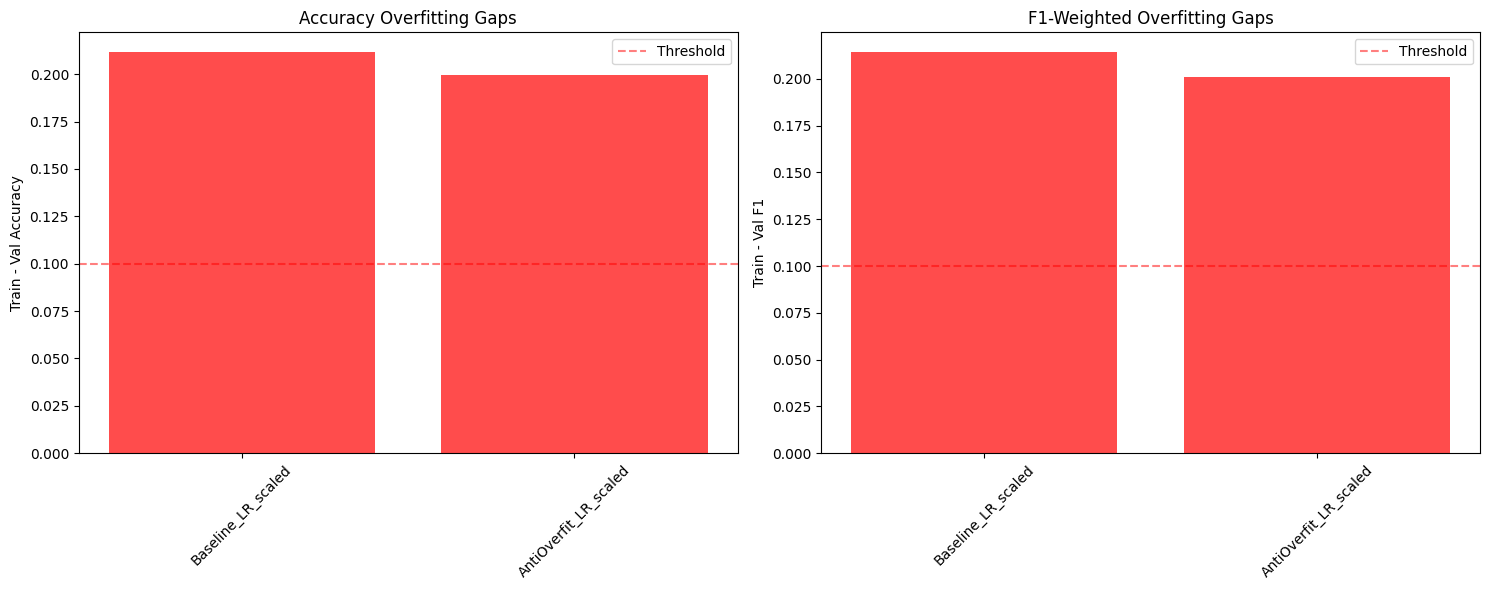

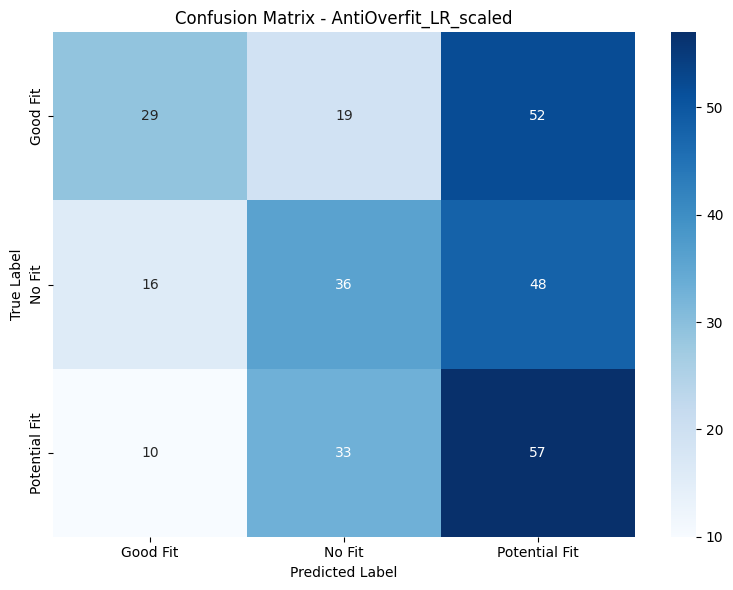

Experiment saved to ../models/trained/LogisticRegression/AntiOverfit_LR_scaled.pkl


In [14]:
# evaluation function to standardise model evaluation
lr_eval_results = evaluate(
    model = lr,
    model_name = lr_name,
    evaluator = evaluator,
    X_train = X_train,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test
)

experiment_name = lr_name

lr_experiment = {
    "experiment_name" : experiment_name,
    "model" : lr,
    "train_results" : lr_train_results,
    "eval_results" : lr_eval_results
}

save_experiment(lr_experiment, f"{experiment_name}.pkl")

# Model Comparison

In [15]:
# Compare all models
comparison_df = evaluator.compare_models()


🏆 MODEL EVALUATION COMPARISON (sorted by Test_F1):
                Model  Train_Acc  Train_F1  Val_Acc  Val_F1 Overfit_Severity  Max_Gap  Test_Acc  Test_F1
AntiOverfit_LR_scaled     0.9027    0.9021   0.7033  0.7010           severe   0.2011    0.4067   0.4003
   Baseline_LR_scaled     0.9190    0.9186   0.7075  0.7045           severe   0.2141    0.3733   0.3704
